In [4]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigoV2

# fake providers contain data from real IBM Quantum devices stored in Qiskit Terra,
# and are useful for extracting realistic noise models.
device = FakeVigoV2()

coupling_map = device.coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'cx', 'measure', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [5]:
from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed
 
estimator = AerEstimator(
    backend_options={
        #"method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, 'shots' : 1024},
    transpile_options={"seed_transpiler": seed},
)

In [6]:
from qiskit.primitives import Estimator
estimator = Estimator()

In [7]:
data = {
    'ec': [],#Evaluation count
    'pm': [],#Parameters
    'em': [],#Elavuated mean
    'es': [],#Evaluated Standard Deviation
    'ef': [],#Entropy of Formation
    'pr': [],#Purity
    'en': [],#Entropy
    'se': [],#Shanon Entropy
    'cc': [] #concurences
}

def store_intermediate_result(eval_count, parameters, mean, std):
    data['ec'].append(eval_count)
    data['pm'].append(parameters)
    data['em'].append(mean)
    data['es'].append(std)


In [8]:
#hamiltonian = SparsePauliOp.from_list([('II', -1), ('IZ', 0.3), ('XI', -0.3), ('ZY', -0.01), ('YX', 0.1)]) 
import qiskit_nature
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False
#install psi4 library   
from qiskit_nature.second_q.drivers import Psi4Driver


def qubit_operator(dist):
    # Define Molecule
    mol = MoleculeInfo(
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  #2*spin + 1
        charge=0,
    )

    prob_unmod = Psi4Driver.from_molecule(mol).run()

    # reducing electron structure by symmetry and Born–Oppenheimer approximation
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(prob_unmod)

    particle_count = problem.num_particles
    spatial_orbitals_count = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=particle_count)
    hamiltonian = mapper.map(problem.second_q_ops()[0])
    return hamiltonian, particle_count, spatial_orbitals_count, problem, mapper

In [9]:
# define ansatz and optimizer
from qiskit.algorithms.optimizers import SPSA

iterations = 125
spsa = SPSA(maxiter=iterations)

In [10]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

def exact_solver(hamiltonian, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)
    result = problem.interpret(sol).total_energies[0].real
    return result

In [11]:
# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
import numpy as np
from qiskit.circuit.library import EfficientSU2

exact_energies = []
vqe_energies = []
circ_ls = []

for i in np.arange(0.3, 2.5, 0.1):
    get_op = qubit_operator(i)
    
    ansatz = EfficientSU2(get_op[0].num_qubits, entanglement="linear")
    vqe = VQE(
        estimator, ansatz, optimizer=spsa
    )
    result = vqe.compute_minimum_eigenvalue(operator=get_op[0]) 
    np_result = exact_solver(get_op[0], get_op[3])
    exact_energies.append(np_result)
    circ_ls.append(result.optimal_circuit)
    vqe_calc = vqe.compute_minimum_eigenvalue(operator=get_op[0])
    vqe_result = get_op[3].interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print('distance:',i,'vqe energy:', vqe_result, 'actual:', np_result)

distance: 0.3 vqe energy: -0.6015161618877858 actual: -0.6018037114169277
distance: 0.4 vqe energy: -0.9141046450722912 actual: -0.9141497050119489
distance: 0.5 vqe energy: -1.0548554235020984 actual: -1.0551597946880158
distance: 0.6000000000000001 vqe energy: -1.115773338381199 actual: -1.1162860069722251
distance: 0.7000000000000002 vqe energy: -1.135859084894339 actual: -1.1361894540879072
distance: 0.8000000000000003 vqe energy: -1.133798554797098 actual: -1.134147666642846
distance: 0.9000000000000001 vqe energy: -1.120452268679887 actual: -1.1205602812268745
distance: 1.0000000000000002 vqe energy: -1.1009335307235983 actual: -1.1011503301329548
distance: 1.1000000000000003 vqe energy: -1.078979128095454 actual: -1.0791929448522475
distance: 1.2000000000000004 vqe energy: -1.0543084906499303 actual: -1.056740746179429
distance: 1.3000000000000005 vqe energy: -1.035002657793738 actual: -1.0351862663067546
distance: 1.4000000000000004 vqe energy: -1.0136247287503442 actual: -1.01

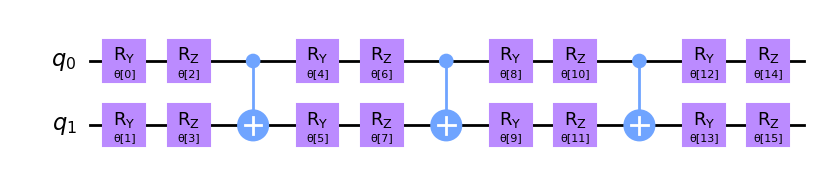

In [12]:
circq = result.optimal_circuit
display(circq.decompose().draw(output='mpl'))

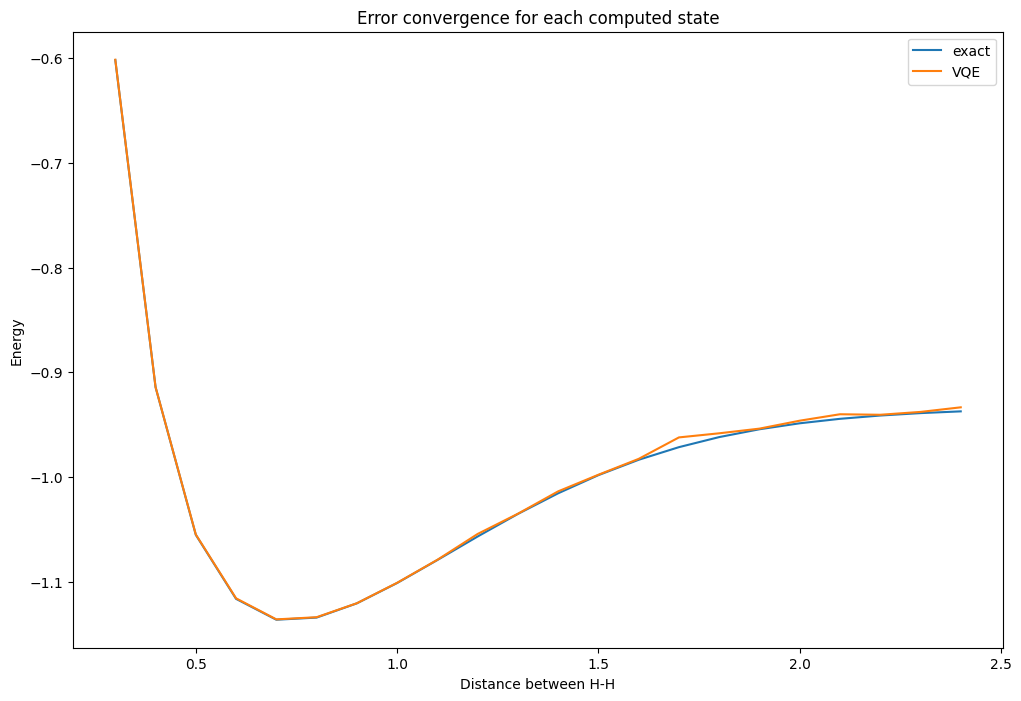

In [13]:
import numpy as np
import matplotlib.pyplot as plt
x = plt
x.rcParams["figure.figsize"] = (12, 8)
x.plot(np.arange(0.3, 2.5, 0.1), exact_energies, label='exact')
x.plot(np.arange(0.3, 2.5, 0.1), vqe_energies, label='VQE')

x.xlabel("Distance between H-H")
x.ylabel('Energy')
x.title("Error convergence for each computed state")
x.legend(loc="upper right")
x.show()